In [13]:
import os
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio.v2 as imageio
import glob
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("dark")
np.random.seed(42)

In [14]:
OUTPUT_DIR = "../output"

In [15]:
samples = 10
parameter_counts = [
    1,
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    30,
    40,
    50,
    100,
    200,
]


os.makedirs(OUTPUT_DIR, exist_ok=True)

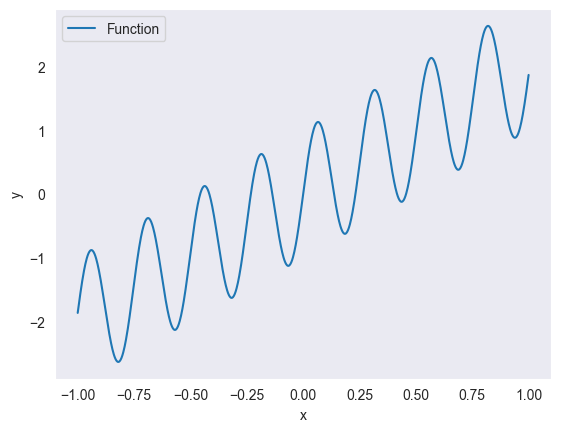

In [16]:
low, high = -1.0, 1.0


def transformed_y(X: np.ndarray):
    return np.add(2.0 * X, np.sin(X * 25))[:, 0]


# Function to approximate
X_test = np.linspace(start=low, stop=high, num=1000).reshape(-1, 1)
y_test = transformed_y(X_test)
plt.close()
sns.lineplot(x=X_test[:, 0], y=y_test, label="Function")
plt.xlabel("x")
plt.ylabel("y")

plt.savefig(
    os.path.join(OUTPUT_DIR, f"data.png"),
    bbox_inches="tight",
    dpi=300,
)
plt.show()
plt.close()

In [17]:
def generate_data(low, high, num_samples):
    X = np.random.uniform(low=low, high=high, size=(num_samples, 1))
    y = transformed_y(X)
    return X, y

In [18]:
from scipy.special import eval_legendre
from sklearn.metrics import mean_squared_error


def fit_polynomial_regression(X_train, y_train, X_test, param_degrees):
    # Fit a polynomial regression model using Legendre polynomials

    X_train_poly = np.column_stack(
        [eval_legendre(d, X_train.flatten()) for d in param_degrees]
    )
    X_test_poly = np.column_stack(
        [eval_legendre(d, X_test.flatten()) for d in param_degrees]
    )

    # Pseudo-inverse to compute regression coefficients
    beta_hat = np.linalg.pinv(X_train_poly) @ y_train
    y_train_pred = X_train_poly @ beta_hat
    y_test_pred = X_test_poly @ beta_hat

    return X_train_poly, y_train_pred, y_test_pred

In [19]:
def plot_fitting(
    X_test, y_test, y_test_pred, X_train, y_train, num_params, directory, repeats
):
    plt.figure()
    sns.lineplot(x=X_test[:, 0], y=y_test, label="Function")
    sns.lineplot(
        x=X_test[:, 0], y=y_test_pred, label=f"Fitted function - {num_params} params"
    )
    sns.scatterplot(x=X_train[:, 0], y=y_train, s=30, color="k", label="Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.ylim(-3, 3)
    plt.legend(loc="upper right")
    plt.savefig(
        os.path.join(directory, f"repeats={repeats}.png"),
        bbox_inches="tight",
        dpi=300,
    )
    plt.close()

In [20]:
def create_fitting_animation(image_dir, output_path, fps=2):
    images = sorted(
        glob.glob(os.path.join(image_dir, "*.png")),
        key=lambda x: int(x.split("=")[-1].split(".")[0]),
    )
    image_list = [imageio.imread(img) for img in images]
    imageio.mimsave(output_path, image_list, fps=fps, loop=0)

In [21]:
def plot_double_descent(fitting_output_df, num_data, output_dir):
    plt.figure(figsize=(12, 8))
    sns.lineplot(
        data=fitting_output_df,
        x="# of Parameters",
        y="Test",
        label="Test",
        marker="D",
    )
    sns.lineplot(
        data=fitting_output_df,
        x="# of Parameters",
        y="Train",
        label="Train",
        marker="D",
    )
    plt.ylabel("MSE")
    plt.xlabel("# of Parameters")
    plt.ylim(bottom=1e-3)
    plt.yscale("log")
    plt.xscale("log")
    plt.title("Polynomial Regression")
    plt.axvline(
        x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
    )
    plt.legend(loc="upper right")

    plt.gcf().tight_layout()
    plot_path = os.path.join(output_dir, "polynomial_double_descent.png")
    plt.savefig(plot_path, bbox_inches="tight", dpi=300)

    plt.show()

In [22]:
def create_double_descent_animation(fitting_output_df, num_data, output_dir):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.set_xlim(1, max(fitting_output_df["# of Parameters"]))
    # ax.set_ylim(min(mse_df["Test MSE"]), max(mse_df["Train MSE"]))
    ax.set_ylim(bottom=1e-3, top=1e7)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_ylabel("Mean Squared Error")
    ax.set_xlabel("Number of Parameters (Num Features)")
    ax.set_title("Polynomial Regression MSE")

    def update(frame):
        ax.clear()
        ax.set_xlim(1, max(fitting_output_df["# of Parameters"]))
        # ax.set_ylim(min(mse_df["Test MSE"]), max(mse_df["Train MSE"]))
        ax.set_ylim(bottom=1e-3, top=1e7)
        ax.set_yscale("log")
        ax.set_xscale("log")
        ax.set_ylabel("MSE")
        ax.set_xlabel("# of Parameters")
        ax.set_title("Polynomial Regression")
        plt.axvline(
            x=num_data, color="black", linestyle="--", label="Interpolation Threshold"
        )
        sns.lineplot(
            data=fitting_output_df[: frame + 1],
            x="# of Parameters",
            y="Test",
            ax=ax,
            label="Test",
            marker="D",
        )

        sns.lineplot(
            data=fitting_output_df[: frame + 1],
            x="# of Parameters",
            y="Train",
            ax=ax,
            label="Train",
            marker="D",
        )

        ax.legend(loc="upper right")
        return ax

    ani = FuncAnimation(fig, update, frames=len(fitting_output_df) + 1, repeat=False)
    gif_path = os.path.join(output_dir, f"polynomial_double_descent.gif")
    ani.save(gif_path, writer="pillow", fps=20)
    plt.close(fig)

In [23]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
fits_per_param = list(range(6))
fitting_output = []

for parameter_count in parameter_counts:
    per_params_dir = os.path.join(OUTPUT_DIR, f"parameter_count={parameter_count}")
    os.makedirs(per_params_dir, exist_ok=True)

    param_degrees = 1 + np.arange(parameter_count).astype(int)
    for repeats in fits_per_param:
        X_train, y_train = generate_data(low, high, samples)
        X_train_poly, y_train_pred, y_test_pred = fit_polynomial_regression(
            X_train, y_train, X_test, param_degrees
        )

        train_mse = mean_squared_error(y_train, y_train_pred)
        test_mse = mean_squared_error(y_test, y_test_pred)

        print(
            f"parameter_count={parameter_count}, repeats={repeats}, train_loss={train_mse:.4f}, test_loss={test_mse:.4f}"
        )

        fitting_output.append(
            {
                "# of Parameters": parameter_count,
                # "repeat_idx": repeats,
                "Train": train_mse,
                "Test": test_mse,
            }
        )

        plot_fitting(
            X_test,
            y_test,
            y_test_pred,
            X_train,
            y_train,
            X_train_poly.shape[1],
            per_params_dir,
            repeats,
        )

    create_fitting_animation(
        per_params_dir,
        os.path.join(per_params_dir, "animation.gif"),
    )

fitting_output_df = pd.DataFrame(fitting_output)

parameter_count=1, repeats=0, train_loss=0.2494, test_loss=0.7266
parameter_count=1, repeats=1, train_loss=0.3629, test_loss=0.5959
parameter_count=1, repeats=2, train_loss=0.5475, test_loss=0.5046
parameter_count=1, repeats=3, train_loss=0.3295, test_loss=0.4989
parameter_count=1, repeats=4, train_loss=0.4372, test_loss=0.5057
parameter_count=1, repeats=5, train_loss=0.5761, test_loss=0.5454
parameter_count=2, repeats=0, train_loss=0.4151, test_loss=0.6257
parameter_count=2, repeats=1, train_loss=0.3215, test_loss=0.9705
parameter_count=2, repeats=2, train_loss=0.3335, test_loss=0.5762
parameter_count=2, repeats=3, train_loss=0.4397, test_loss=0.5054
parameter_count=2, repeats=4, train_loss=0.4264, test_loss=0.5845
parameter_count=2, repeats=5, train_loss=0.3718, test_loss=0.5341
parameter_count=3, repeats=0, train_loss=0.2488, test_loss=0.6245
parameter_count=3, repeats=1, train_loss=0.3671, test_loss=0.5812
parameter_count=3, repeats=2, train_loss=0.0883, test_loss=0.8813
parameter_

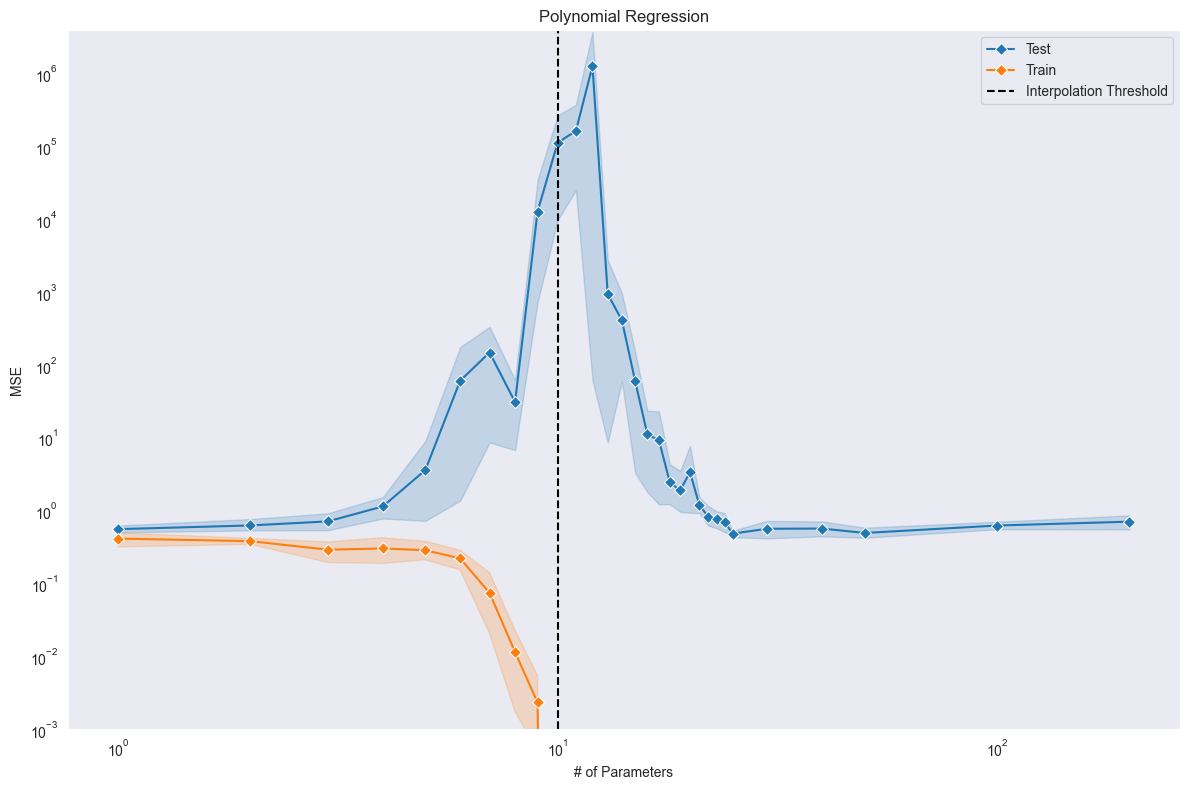

In [24]:
create_double_descent_animation(fitting_output_df, samples, OUTPUT_DIR)
plot_double_descent(fitting_output_df, samples, OUTPUT_DIR)